In [1]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import numpy as np
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#ツイートのテキスト読み込み
test = open("extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [3]:
#userID
test = open("user.txt","r", encoding="utf-8")
uID = test.readlines()
test.close()
print(len(uID))

10000


In [4]:
id_list = []
for i in uID:
    if i in id_list:
        continue
    else:
        id_list.append(i)

In [5]:
print(len(id_list))

32


In [6]:
post_user = []
for i in uID:
    for j in range(len(id_list)):
        if i == id_list[j]:
            post_user.append(j)

In [7]:
n_postUser = np.array(post_user)

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 50
train = 0.7
validation = 0.1
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
users = n_postUser[indices]

indices = [int(len(labels) * n) for n in [train, train + validation]]
x1_train, x1_val, x1_test = np.split(data, indices)
x2_train, x2_val, x2_test = np.split(users, indices)
y_train, y_val, y_test = np.split(labels, indices)

Found 18881 unique tokens.
Shape of data tensor:(10000, 50)
Shape of label tensor:(10000, 2)


In [2]:
import keras.backend as K
from functools import partial

def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [3]:
p_input = Input(shape=(50, ), dtype='int32', name='Input_postText')
i_input = Input(shape=(1, ), name='Input_ids')

#テキストの学習
em = Embedding(input_dim=20000, output_dim=50, input_length=50, name='Embedding')(p_input)
d_em = Dropout(0.5)(em)
lstm_out = LSTM(32, name='LSTM')(d_em)
d_lstm_out = Dropout(0.5)(lstm_out)
#2つ目のデータ学習
i2 = Dense(16, activation='relu', name = 'dence1')(i_input)
d_i2 = Dropout(0.5)(i2)
x = concatenate([d_lstm_out, d_i2], name='merge1')

m2 = Dense(16, activation='relu', name = 'dence')(x)
d_m2 = Dropout(0.5)(m2)
output = Dense(2, activation='softmax', name = 'output')(d_m2)

optimizer = Adam(lr=1e-3)
model = Model(inputs=[p_input, i_input], outputs = output)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_image/model2.png')


early_stopping = EarlyStopping(patience=2, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_postText (InputLayer)     (None, 50)           0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 50, 50)       1000000     Input_postText[0][0]             
__________________________________________________________________________________________________
Input_ids (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 32)           10624       Embedding[0][0]                  
__________________________________________________________________________________________________
dence1 (De

In [11]:
history = model.fit([x1_train, x2_train], y_train,
                    epochs=100, 
                    batch_size=256,
                    validation_data=([x1_val, x2_val], y_val))

Train on 7000 samples, validate on 999 samples
Epoch 1/100
7000/7000 [==============================] - 5s 644us/step - loss: 3.5847 - acc: 0.5029 - macro_precision: 0.5038 - macro_recall: 0.5027 - macro_f_measure: 0.5030 - val_loss: 1.0311 - val_acc: 0.4915 - val_macro_precision: 0.4937 - val_macro_recall: 0.4943 - val_macro_f_measure: 0.4940
Epoch 2/100
7000/7000 [==============================] - 2s 336us/step - loss: 2.1759 - acc: 0.4980 - macro_precision: 0.4980 - macro_recall: 0.4981 - macro_f_measure: 0.4980 - val_loss: 0.6818 - val_acc: 0.5536 - val_macro_precision: 0.7080 - val_macro_recall: 0.5450 - val_macro_f_measure: 0.6157
Epoch 3/100
7000/7000 [==============================] - 2s 331us/step - loss: 1.4134 - acc: 0.5110 - macro_precision: 0.5107 - macro_recall: 0.5107 - macro_f_measure: 0.5107 - val_loss: 0.6866 - val_acc: 0.5526 - val_macro_precision: 0.5633 - val_macro_recall: 0.5477 - val_macro_f_measure: 0.5554
Epoch 4/100
7000/7000 [==============================] -

7000/7000 [==============================] - 2s 337us/step - loss: 0.0645 - acc: 0.9706 - macro_precision: 0.9709 - macro_recall: 0.9707 - macro_f_measure: 0.9708 - val_loss: 1.6608 - val_acc: 0.7467 - val_macro_precision: 0.7498 - val_macro_recall: 0.7464 - val_macro_f_measure: 0.7481
Epoch 56/100
7000/7000 [==============================] - 2s 339us/step - loss: 0.0687 - acc: 0.9689 - macro_precision: 0.9691 - macro_recall: 0.9689 - macro_f_measure: 0.9690 - val_loss: 1.6979 - val_acc: 0.7457 - val_macro_precision: 0.7475 - val_macro_recall: 0.7455 - val_macro_f_measure: 0.7465
Epoch 57/100
7000/7000 [==============================] - 2s 334us/step - loss: 0.0683 - acc: 0.9671 - macro_precision: 0.9675 - macro_recall: 0.9671 - macro_f_measure: 0.9673 - val_loss: 1.7004 - val_acc: 0.7407 - val_macro_precision: 0.7421 - val_macro_recall: 0.7404 - val_macro_f_measure: 0.7412
Epoch 58/100
7000/7000 [==============================] - 2s 331us/step - loss: 0.0742 - acc: 0.9683 - macro_prec

In [17]:
loss_and_metrics = model.evaluate([x1_test, x2_test], y_test)
print(loss_and_metrics)

2001/2001 [==============================] - 2s 871us/step
[2.2534623371101152, 0.7421289355918087, 0.7501013090108883, 0.7424290433697317, 0.7461144985823795]


In [13]:
classes = model.predict([x1_test, x2_test])
np.savetxt('Mult_predict.csv', classes, delimiter = ',')

In [14]:
model.metrics_names

['loss', 'acc', 'macro_precision', 'macro_recall', 'macro_f_measure']

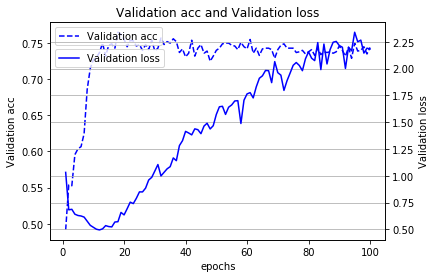

In [18]:
import matplotlib.pyplot as plt

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(1, len(val_acc) + 1)

fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')

plt.show()

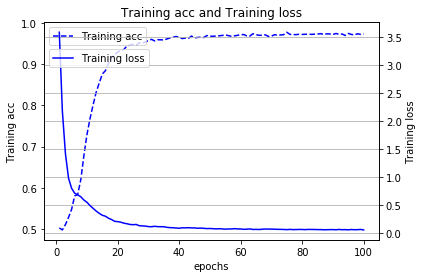

In [15]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(val_acc) + 1)

fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Training loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

plt.show()

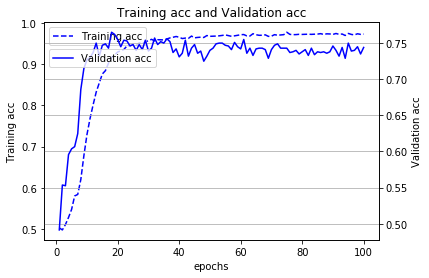

In [16]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Validation acc')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation acc')

plt.show()